In [1]:
import numpy as np
import scipy
import scipy.linalg
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

from numerical_eqs.utils import SimTime
from sdole import SDOLESolver
from utils import tridiag_mult


In [2]:
{ **{'a':5, 'b': 1}, **{'a': 1, 'c': 2} }

{'a': 1, 'b': 1, 'c': 2}

In [6]:
class DiffusionSolver(SDOLESolver):
    
    def __init__(self, t0, t1, d_func, e_func):
        super().__init__(t0, t1)
        self.d_func = d_func
        self.e_func = e_func
        
    def step_raw ( self, t, U, dt ):
        '''Takes a single step
        '''
#         print(U)
        theta = 1
        
        M, S = self.mats
        
        # Assemble our utility matrix
        Q = (M / dt) + (theta * S)

        # Solve for our new step size
        R = -1 * tridiag_mult(S, U)

        

        for i, b in zip((0,-1), self.boundaries):
            # Set the delta numerically, so that dU + U is known (=f(t)) for t+dt
            if b.get('type') == 'dirichlet':
                Q[1, -1] = 1
                Q[2,-2] = 0
                R[i] = b.get('f')(t) - U[i]

            # Just add in the flux on the particular side
            elif b.get('type') == 'neumann':
                R[i] += b.get('f')(t)


        dU = scipy.linalg.solve_banded(
            (1,1),
            Q, R,
            overwrite_ab = True,
            overwrite_b = True
        )

        return dU

        

In [21]:
mesh = np.linspace(0, 10, 15, endpoint=True)
u0 = 0 * mesh
t0, t1 = (0, 1)

boundaries = (
    {'type': 'neumann', 'f': lambda t: 0},
    {'type': 'dirichlet', 'f': lambda t: np.sin(t)*np.exp(-t)},
)
dim_func = lambda x: x

pde = DiffusionSolver(t0, t1, dim_func, dim_func)
res = pde.solve(
    u0,
    mesh,
    boundaries,
    time_controls={
        'dtmin': 0.001,
        'dtmax': 0.1
    }
)


  0%|          | 0/1 [00:00<?, ?it/s]
 13%|█▎        | 0.1340000000000001/1 [00:00<00:00,  1.34it/s]
 27%|██▋       | 0.2680000000000002/1 [00:00<00:00,  1.12it/s]
 39%|███▉      | 0.3890000000000003/1 [00:00<00:00,  1.16it/s]
 55%|█████▌    | 0.5530000000000004/1 [00:00<00:00,  1.33it/s]
 72%|███████▏  | 0.7180000000000005/1 [00:00<00:00,  1.44it/s]
100%|██████████| 1.0/1 [00:00<00:00,  1.42it/s]               


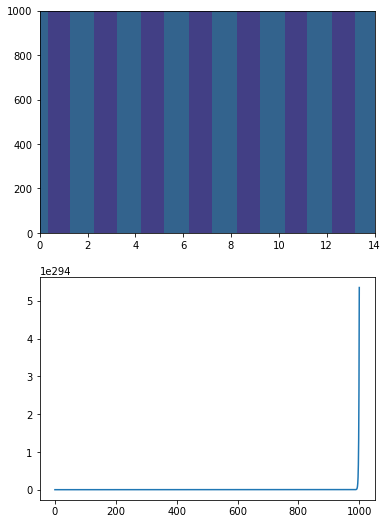

In [22]:
# res['res'][2]
fig, axs = plt.subplots(2, figsize=(6,9))
axs[0].contourf(
    res['res'],
)
axs[1].plot(
    res['res'][:,-1]
)
plt.plot()
None